# **Exploring Quantum Algorithms**

**Rubén Parte Pombo**

## **Abstract**

In this project, I applied quantum computing techniques on a company bankruptcy prediction problem, leveraging a CQ (classical-quantum) approach. I explored various quantum algorithms, including Quantum Support Vector Algorithms (QSVC) and Variational Quantum Algorithms (VQAs), while also experimenting with different dimensionality reduction techniques to enhance prediction accuracy.

## **Dataset Loading**

Firstly, the libraries are installed.

In [ ]:
%pip install -r requirements.txt

# requirements contains the following libreries: 
# kagglehub==0.3.6 
# scikit-learn==1.2.2
# pennylane==0.39.0
# tensorflow==2.15
# silence-tensorflow
# pandas
# matplotlib
# seaborn
# numpy
# qiskit
# qiskit-ibm-runtime
# pennylane-qiskit

Note: you may need to restart the kernel to use updated packages.


In [19]:
import kagglehub
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, hinge_loss
from sklearn.decomposition import PCA
import pennylane as qml
import tensorflow as tf
import random
import qiskit
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler


rs=1234
random.seed(rs)
np.random.seed(rs)
tf.random.set_seed(rs)

from silence_tensorflow import silence_tensorflow

silence_tensorflow()

As part of the initial setup, the following function imports my secret IBM Quantum token from a json file.

In [20]:
import json

def load_ibm_token(token_file="ibm_token.json"):
    try:
        with open(token_file, "r") as file:
            data = json.load(file)
            return data["ibm_quantum_token"]
    except FileNotFoundError:
        raise FileNotFoundError(f"Token file '{token_file}' not found.")
    except KeyError:
        raise KeyError("Token not found in the JSON file. Ensure the key is 'ibm_quantum_token'.")


The dataset is loaded from Kaggle, and a summary is displayed. It consists of 96 numeric columns, with the first one being the binary label.

In [3]:
path = kagglehub.dataset_download("fedesoriano/company-bankruptcy-prediction")

df = pd.read_csv(os.path.join(path, "data.csv"))
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

## **Exploratory Data Analysis**

### **Class balance solution**

It's important to check whether the classes in the target variable are balanced.

In [4]:
df['Bankrupt?'].value_counts()

Bankrupt?
0    6599
1     220
Name: count, dtype: int64

There is a clear imbalance between classes 0 and 1. To address this issue, undersampling is applied to class 0. Rows are shuffled both before and after the undersampling.

In [5]:
xdf = df.sample(frac = 1)


df_0 = df.loc[xdf['Bankrupt?'] == 0][:220]
df_1 = df.loc[xdf['Bankrupt?']==1]

normal_distributed_df = pd.concat([df_0, df_1])
normal_distributed_df = normal_distributed_df.sample(frac = 1, random_state = 42)

normal_distributed_df['Bankrupt?'].value_counts()


Bankrupt?
1    220
0    220
Name: count, dtype: int64

### **Data split into train and test**

In [6]:
X = normal_distributed_df.drop(columns=['Bankrupt?'])
y = normal_distributed_df['Bankrupt?']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y , random_state=1234)

### **Correlation Matrix**

The following code calculates the correlation matrix between all the attributes and counts the number of variable pairs with a correlation greater than 90%.

In [7]:
correlation_matrix = X_train.corr()

threshold = 0.9

count = 0
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            count += 1

print(f"Número de correlaciones mayores que {threshold * 100}%: {count}")


Número de correlaciones mayores que 90.0%: 43


### **Dimensionality reduction**

With 95 explanatory variables, it is necessary to use a dimensionality reduction method that fits the characteristics of the problem to be solved. Several options are available (PCA, LDA, UMAP, etc.).

LDA and PCA have been selected for the following reasons:

**LDA (Linear Discriminant Analysis)**
* It considers class labels during dimensionality reduction and maximizes the separation between classes.
* Studies have shown improved performance in quantum classifiers when using Linear Discriminant Analysis during data preprocessing. **[1]**
* There is an option to implement QLDADR (Quantum Linear Discriminant Analysis with Dimensionality Reduction). However, due to its practical limitations and higher complexity, it has been referenced but not implemented. **[2]**
* A disadvantage is that, for a binary class problem(2 classes), the number of components after the reduction will be limited to num_classes-1 = 1.


**PCA (Principal Component Analysis)**
* It allows retaining a larger number of components.
* It is an unsupervised method that does not take class labels into account.

In [8]:
# LDA
lda = LinearDiscriminantAnalysis(n_components=1)

X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

print("Projection of the data after LDA:")
print(X_train_lda[:3])

Projection of the data after LDA:
[[ 2.1117138 ]
 [-0.89507134]
 [-2.38870273]]


The PCA approach reduces the number of components compared to higher explained variance thresholds, thereby lowering the computational cost.

In [9]:
pca = PCA()
pca.fit(X_train)
explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.argmax(explained_variance >= 0.90) + 1 # se suma 1 por los indices en python

pca = PCA(n_components = n_components_90)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print(f"Projection of the data after PCA with {n_components_90} components:")
print(X_train_pca[:3])

Projection of the data after PCA with 7 components:
[[ 1.98698816e+09 -4.09867917e+09 -7.10943100e+08 -6.19396277e+08
  -6.16510973e+09  3.77413919e+09  2.74760337e+09]
 [ 6.86466978e+08 -2.19757740e+09 -7.18569445e+08 -1.58561657e+09
  -2.19950752e+09 -1.87927619e+09  5.70357907e+09]
 [ 5.17166752e+09 -5.70844056e+08 -4.33354881e+09 -1.22688335e+08
   2.12762491e+09 -5.50343110e+08 -3.60682115e+09]]


### **Angle embedding**

Angle embedding was chosen because it is a straightforward and effective method for encoding classical data into quantum states. By scaling the features to the range (0,π), the data can be directly used as parameters for quantum gates.

In [10]:
scaler = MinMaxScaler(feature_range=(0,np.pi))

X_train_lda_angle = scaler.fit_transform(X_train_lda)
X_test_lda_angle = scaler.transform(X_test_lda)

X_train_pca_angle = scaler.fit_transform(X_train_pca)
X_test_pca_angle = scaler.transform(X_test_pca)

## **Quantum support vector machines**

QSVC uses a similar structure of an SVC, but ours is boosted with a quantum kernel. Since the dimensionality of the data differs depending on the reduction method applied, a different kernel will be created for each method.

 There are three basic **encoding methods**: basis, rotation, and amplitude. In this project, rotation encoding is employed for QSVCs, while the other methods will be discussed in subsequent sections.

The first kernel uses 1 qubit, as **AngleEmbedding** encodes N features into n qubits, where N<=n, and the LDA-projected data has a dimensionality of 1.

In [11]:
n_qubits = 1
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def kernel(x1, x2):
    # Codificación de los datos clásicos en el qubit con angle embedding
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(qml.templates.AngleEmbedding(x2, wires=range(n_qubits)))
    # Medición de probabilidades
    return qml.probs(wires=range(n_qubits))

# Función para calcular la matriz del kernel
def kernel_matrix(A, B):
    return np.array([[kernel(a, b)[0] for b in B] for a in A])

Once the kernel is created, an SVC model is trained using the LDA-projected data.  

In [27]:
svm = SVC(kernel=kernel_matrix).fit(X_train_lda_angle, y_train)
predictions_lda = svm.predict(X_test_lda_angle)
accuracy_qsvc_lda = accuracy_score(predictions_lda, y_test)
print(f"Accuracy: {accuracy_qsvc_lda}")

decision_scores = svm.decision_function(X_test_lda_angle)
loss_qsvc_lda = hinge_loss(y_test, decision_scores)
print(f"Loss: {loss_qsvc_lda}")

Accuracy: 0.8636363636363636
Loss: 0.3348800379261398


Similarly, a second kernel and QSVC model are trained using the data projected through PCA. This model utilizes 8 qubits, matching the dimensionality of the data.

In [28]:
n_qubits = n_components_90
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def kernel(x1, x2):
    # Codificación de los datos clásicos en el qubit con angle embedding
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(qml.templates.AngleEmbedding(x2, wires=range(n_qubits)))
    # Medición de probabilidades
    return qml.probs(wires=range(n_qubits))

# Función para calcular la matriz del kernel
def kernel_matrix(A, B):
    return np.array([[kernel(a, b)[0] for b in B] for a in A])

In [29]:
svm = SVC(kernel=kernel_matrix).fit(X_train_pca_angle, y_train)
predictions_pca = svm.predict(X_test_pca_angle)
accuracy_qsvc_pca = accuracy_score(predictions_pca, y_test)
print(f"Accuracy: {accuracy_qsvc_pca}")

decision_scores = svm.decision_function(X_test_pca_angle)
loss_qsvc_pca = hinge_loss(y_test, decision_scores)
print(f"Loss: {loss_qsvc_pca}")

Accuracy: 0.6022727272727273
Loss: 0.8381770039877342


The experiments with quantum support vector machines demonstrated that using LDA data resulted in better accuracy, lower loss and faster outcomes compared to using PCA data.

## **Variational Quantum Algorithms**

This type of architecture involves a feedback loop containing
 quantum learning layers and classical parameter adjustment.

 Each gate and operation are parametrized by trainable weights, which
 are trained to minimize a cost function.

### **Quantum Neural Networks**

Although Quantum Neural Networks (QNNs) face significant challenges due to vanishing gradients, commonly known as barren plateaus **[3]**. However, the scale of our experiments, with a limited number of qubits, reduces the likelihood of encountering these issues. This makes QNNs a suitable choice for our work.

**Dynamical Decoupling** techniques are applied in the quantum neural network to enhance robustness against decoherence. By inserting sequences of X gates after the qubits become entangled, the circuit helps mitigate noise effects, making it more suitable for simulations on NISQ devices. **[4]**

The following function was created to reuse the code, as the number of qubits changes depending on whether LDA or PCA data is used. It constructs the quantum circuit and a neural network, which are then trained and tested on the data provided as input to the function.

Additionally, the function includes an option to run the quantum circuit on an IBM quantum computer using the Pennylane-Qiskit plugin **[5]**. Unfortunately, errors encountered could not be resolved. Further explanations are provided in the "Further Work" section.

In [25]:
def train_eval_qnn(X_train, y_train, X_test, y_test, n_qubits, encoding , n_layers=3, device="simulation" ,learning_rate=0.05, epochs=100, validation_split=0.2, patience=20):
    """
    Trains a Quantum Neural Network (QNN) based on the given data and parameters.

    Args:
      X_train: Input data for training.
      y_train: Corresponding labels for the training data.
      X_test: Test data for evaluation.
      y_test: Test labels for evaluation.
      n_qubits: Number of qubits to use in the quantum circuit.
      encoding: Encoding technique to use ('angle' or 'amplitude').
      n_layers: Number of layers for the quantum entanglement (default is 3).
      device: The quantum device to use ('simulation' or 'ibmq', default is 'simulation').
      learning_rate: Learning rate for the optimizer (default is 0.05).
      epochs: Maximum number of training epochs (default is 100).
      validation_split: Proportion of the training data to use for validation (default is 0.2).
      patience: Early stopping patience (default is 20).

    Returns:
      history: The training history object from the model, containing details such as loss and accuracy per epoch.
      test_results: Evaluation metrics (e.g., loss and accuracy) on the test dataset.
    """


    if device == "simulation":
      # Define the quantum device
      dev = qml.device("default.qubit", wires=n_qubits)

    
    elif device == "ibmq":
      my_token = load_ibm_token()
      QiskitRuntimeService.save_account(channel="ibm_quantum", token = my_token, overwrite=True)
      # To access saved credentials for the IBM quantum channel and select an instance
      service = QiskitRuntimeService(channel="ibm_quantum", instance="ibm-q/open/main") # The free accounts belong to ibm-q/open/main
      backend = service.least_busy(operational=True, simulator=False, min_num_qubits= n_qubits)
      print("least busy backend: ", backend)
      # Set the maximum session time to prevent the session from closing due to too many queued jobs (previously encountered error 1217)
      
      with Session(backend=backend, max_time="30m") as session:
        dev = qml.device('qiskit.remote', wires=n_qubits, backend=backend)
        
        # sampler = Sampler(session=session)
        # dev = qml.device("qiskit.remote", wires=n_qubits, sampler=sampler)

    else:
      raise ValueError("Device must be either 'simulation' or 'ibmq'.")

    # Define the QNode
    @qml.qnode(dev)
    def qnode(inputs, weights):
        if encoding == "angle":
          # Data embedding using AngleEmbedding
          qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
        elif encoding == "amplitude":
          # Data embedding using AmplitudeEmbedding
          qml.templates.AmplitudeEmbedding(features=inputs, wires=range(n_qubits), pad_with=0., normalize=True)
        else:
          raise ValueError("Encoding must be either 'angle' or 'amplitude'.")

        # Entanglement layer
        qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))

        # Dynamical Decoupling
        for qubit in range(n_qubits):
            qml.PauliX(wires=qubit)
            qml.PauliX(wires=qubit)

        # Measurement of the |0> basis state on the first qubit
        state_0 = [[1], [0]]
        y = state_0 * np.conj(state_0).T
        return [qml.expval(qml.Hermitian(y, wires=[0]))]


    weight_shapes = {"weights": (n_layers, n_qubits, 3)}


    # Create the quantum layer
    qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

    # Build the model
    model = tf.keras.models.Sequential([qlayer])
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

    # Define early stopping
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, validation_split=validation_split, callbacks=[early_stopping_cb])
    pd.DataFrame(history.history).plot(figsize=(8, 5));

    # Evaluate the model on test data
    test_results = model.evaluate(X_test, y_test)

    return history, test_results

#### Angle Embedding

First, we apply the function using the LDA data.

Epoch 1/100
9/9 [==============================] - 2s 195ms/step - loss: 1.2093 - accuracy: 0.4057 - val_loss: 0.4326 - val_accuracy: 0.7887
Epoch 2/100
9/9 [==============================] - 2s 177ms/step - loss: 0.3850 - accuracy: 0.8577 - val_loss: 0.4566 - val_accuracy: 0.8592
Epoch 3/100
9/9 [==============================] - 2s 185ms/step - loss: 0.3759 - accuracy: 0.9110 - val_loss: 0.2665 - val_accuracy: 0.9437
Epoch 4/100
9/9 [==============================] - 2s 183ms/step - loss: 0.2818 - accuracy: 0.9217 - val_loss: 0.2797 - val_accuracy: 0.9437
Epoch 5/100
9/9 [==============================] - 2s 191ms/step - loss: 0.2738 - accuracy: 0.9253 - val_loss: 0.2567 - val_accuracy: 0.9296
Epoch 6/100
9/9 [==============================] - 2s 189ms/step - loss: 0.2683 - accuracy: 0.9288 - val_loss: 0.2892 - val_accuracy: 0.9155
Epoch 7/100
9/9 [==============================] - 2s 178ms/step - loss: 0.2743 - accuracy: 0.9324 - val_loss: 0.2557 - val_accuracy: 0.9437
Epoch 8/100
9

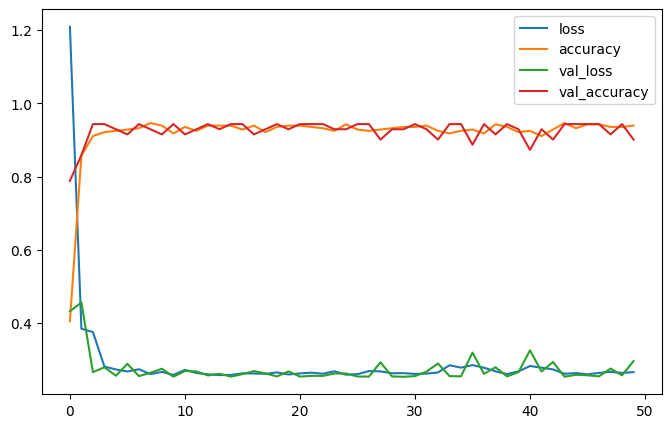

In [30]:
history_lda, test_results_lda = train_eval_qnn(X_train_lda_angle, y_train, X_test_lda_angle, y_test, n_qubits=1, encoding="angle", n_layers = 10, device="simulation")

The same process is then applied to the PCA data.

Epoch 1/100
9/9 [==============================] - 14s 2s/step - loss: 0.6692 - accuracy: 0.5907 - val_loss: 0.6284 - val_accuracy: 0.6761
Epoch 2/100
9/9 [==============================] - 13s 1s/step - loss: 0.6238 - accuracy: 0.6655 - val_loss: 0.6281 - val_accuracy: 0.7042
Epoch 3/100
9/9 [==============================] - 15s 2s/step - loss: 0.6015 - accuracy: 0.7082 - val_loss: 0.6475 - val_accuracy: 0.5915
Epoch 4/100
9/9 [==============================] - 15s 2s/step - loss: 0.5980 - accuracy: 0.6655 - val_loss: 0.6265 - val_accuracy: 0.6479
Epoch 5/100
9/9 [==============================] - 13s 1s/step - loss: 0.6008 - accuracy: 0.6833 - val_loss: 0.6240 - val_accuracy: 0.6479
Epoch 6/100
9/9 [==============================] - 13s 1s/step - loss: 0.5941 - accuracy: 0.7011 - val_loss: 0.6439 - val_accuracy: 0.6620
Epoch 7/100
9/9 [==============================] - 13s 2s/step - loss: 0.5899 - accuracy: 0.7011 - val_loss: 0.6315 - val_accuracy: 0.6761
Epoch 8/100
9/9 [==========

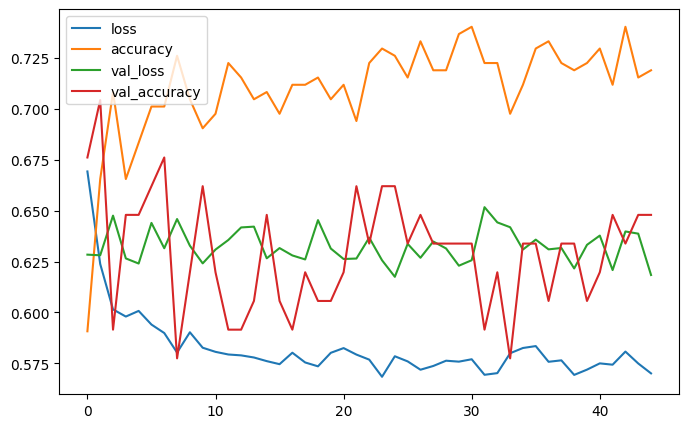

In [31]:
history_pca, test_results_pca = train_eval_qnn(X_train_pca_angle, y_train, X_test_pca_angle, y_test, n_qubits=n_components_90, encoding="angle", n_layers = 10, device="simulation")

#### Amplitude Embedding

Until now, rotation encoding was the only approach tried. Now, **amplitude encoding** is also explored as it performs well with low-depth networks and continuous data **[4]**.

First, we apply the function using the LDA data. Note that the input data is not manually normalized in this case, as AmplitudeEmbedding automatically normalizes it.

Epoch 1/100
9/9 [==============================] - 2s 177ms/step - loss: 0.9729 - accuracy: 0.4591 - val_loss: 0.6657 - val_accuracy: 0.6197
Epoch 2/100
9/9 [==============================] - 2s 176ms/step - loss: 0.7314 - accuracy: 0.4804 - val_loss: 0.7527 - val_accuracy: 0.3803
Epoch 3/100
9/9 [==============================] - 2s 173ms/step - loss: 0.7129 - accuracy: 0.4591 - val_loss: 0.7711 - val_accuracy: 0.3803
Epoch 4/100
9/9 [==============================] - 2s 176ms/step - loss: 0.7140 - accuracy: 0.5267 - val_loss: 0.6666 - val_accuracy: 0.6197
Epoch 5/100
9/9 [==============================] - 2s 174ms/step - loss: 0.7340 - accuracy: 0.4235 - val_loss: 0.7076 - val_accuracy: 0.3803
Epoch 6/100
9/9 [==============================] - 2s 170ms/step - loss: 0.7121 - accuracy: 0.4662 - val_loss: 0.7426 - val_accuracy: 0.3803
Epoch 7/100
9/9 [==============================] - 2s 170ms/step - loss: 0.7054 - accuracy: 0.4840 - val_loss: 0.6954 - val_accuracy: 0.3803
Epoch 8/100
9

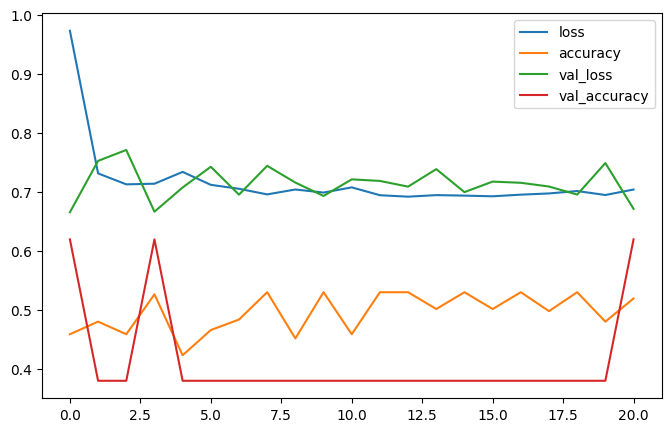

In [32]:
history_lda, test_results_amp_lda = train_eval_qnn(X_train_lda, y_train, X_test_lda, y_test, n_qubits=1, encoding="amplitude", n_layers = 10, device="simulation")

Same is done for the PCA data.

Epoch 1/100
9/9 [==============================] - 12s 1s/step - loss: 0.7309 - accuracy: 0.4840 - val_loss: 0.6458 - val_accuracy: 0.6479
Epoch 2/100
9/9 [==============================] - 13s 1s/step - loss: 0.6569 - accuracy: 0.6157 - val_loss: 0.6399 - val_accuracy: 0.6197
Epoch 3/100
9/9 [==============================] - 13s 1s/step - loss: 0.6412 - accuracy: 0.6441 - val_loss: 0.6337 - val_accuracy: 0.6620
Epoch 4/100
9/9 [==============================] - 13s 1s/step - loss: 0.6366 - accuracy: 0.6370 - val_loss: 0.6339 - val_accuracy: 0.6479
Epoch 5/100
9/9 [==============================] - 13s 1s/step - loss: 0.6309 - accuracy: 0.6833 - val_loss: 0.6334 - val_accuracy: 0.6056
Epoch 6/100
9/9 [==============================] - 13s 1s/step - loss: 0.6254 - accuracy: 0.6584 - val_loss: 0.6315 - val_accuracy: 0.6056
Epoch 7/100
9/9 [==============================] - 13s 1s/step - loss: 0.6354 - accuracy: 0.6690 - val_loss: 0.6573 - val_accuracy: 0.5493
Epoch 8/100
9/9 [==========

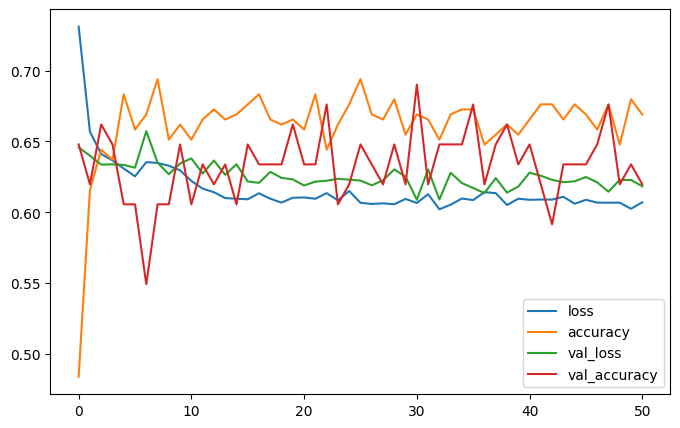

In [33]:
history_pca, test_results_amp_pca = train_eval_qnn(X_train_pca, y_train, X_test_pca, y_test, n_qubits=n_components_90, encoding="amplitude", n_layers = 10, device="simulation")

The quantum neural network using LDA data and angle encoding clearly resulted the better performer. However, it should be interesting to work with more than one dimension, as working with ahigher amount of qubits would lead to better learning of the info the neural network. 

### **Hybrid Quantum Neural Networks**

Using a classical layer at the beginning of the structure allows the model to handle high-dimensional data effectively. Therefore, the original dataset, with all 96 dimensions, can be directly passed into the hybrid network. This classical preprocessing prepares the data before it is processed by the quantum layers.

In [35]:
def train_eval_hybrid_qnn(X_train, y_train, X_test, y_test, n_qubits, n_layers, input_dimension):
  dev = qml.device("default.qubit", wires=n_qubits)

  @qml.qnode(dev)
  def qnode(inputs, weights):
      qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
      qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
      return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

  weight_shapes = {"weights": (n_layers, n_qubits, 3)}

  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(n_qubits,activation='relu',input_dim = input_dimension, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
  model.add(qml.qnn.KerasLayer(qnode, weight_shapes, output_dim = n_qubits))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  opt = tf.keras.optimizers.Adam(learning_rate=0.05)
  model.compile(loss='binary_crossentropy', optimizer = opt, metrics=["accuracy"])


  early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
  history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping_cb])

  pd.DataFrame(history.history).plot(figsize=(8, 5));

  test_results = model.evaluate(X_test, y_test)

  return history, test_results

As Angle Embedding is used to encode the data into the quantum circuit, the original data is scaled to [0, π].

In [36]:
scaler = MinMaxScaler(feature_range=(0,np.pi))

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Epoch 1/100
9/9 [==============================] - 22s 2s/step - loss: 0.8490 - accuracy: 0.5267 - val_loss: 0.9196 - val_accuracy: 0.3944
Epoch 2/100
9/9 [==============================] - 21s 2s/step - loss: 0.8641 - accuracy: 0.5694 - val_loss: 0.8449 - val_accuracy: 0.6761
Epoch 3/100
9/9 [==============================] - 19s 2s/step - loss: 0.8325 - accuracy: 0.5943 - val_loss: 0.8439 - val_accuracy: 0.5070
Epoch 4/100
9/9 [==============================] - 20s 2s/step - loss: 0.7677 - accuracy: 0.6726 - val_loss: 0.7881 - val_accuracy: 0.6479
Epoch 5/100
9/9 [==============================] - 21s 2s/step - loss: 0.6886 - accuracy: 0.7794 - val_loss: 0.7232 - val_accuracy: 0.6479
Epoch 6/100
9/9 [==============================] - 19s 2s/step - loss: 0.6820 - accuracy: 0.7544 - val_loss: 0.6427 - val_accuracy: 0.7606
Epoch 7/100
9/9 [==============================] - 19s 2s/step - loss: 0.7285 - accuracy: 0.6584 - val_loss: 0.6952 - val_accuracy: 0.7465
Epoch 8/100
9/9 [==========

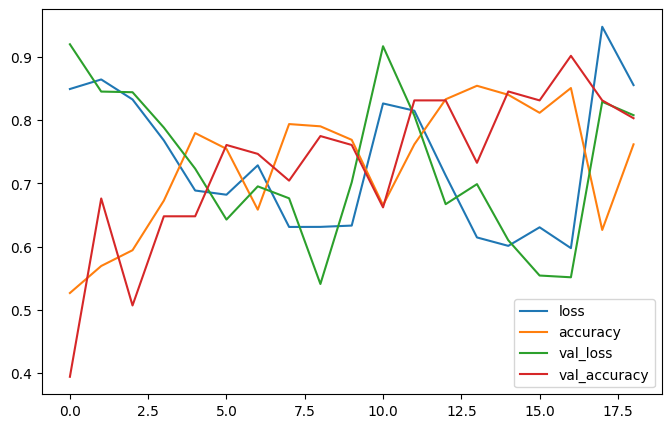

In [37]:
history_hqnn, test_results_hqnn = train_eval_hybrid_qnn(X_train, y_train, X_test, y_test, n_qubits = 8, n_layers = 10, input_dimension = 95)

## Conclusions

The results show that the best performance was achieved with **LDA** and **Angle Embedding**. The **QSVC_LDA** and **QNN_Angle_LDA** models significantly outperformed those using **PCA** or **Amplitude Embedding**, which had lower accuracy and higher loss. The **Hybrid QNN** model performed poorly, likely due to the challenge of managing 95 attributes in the first layers.

To improve future results, increasing the number of qubits, experimenting with different dimensionality reduction techniques, fine-tuning hyperparameters, and optimizing hybrid quantum-classical approaches could lead to better performance.

In [38]:
results = {
    "QSVC_LDA": {"accuracy": accuracy_qsvc_lda, "loss": loss_qsvc_lda}, 
    "QSVC_PCA": {"accuracy": accuracy_qsvc_pca, "loss": loss_qsvc_pca},
    "QNN_Angle_LDA": {"accuracy": test_results_lda[1], "loss": test_results_lda[0]},
    "QNN_Angle_PCA": {"accuracy": test_results_pca[1], "loss": test_results_pca[0]},
    "QNN_Amplitude_LDA": {"accuracy": test_results_amp_lda[1], "loss": test_results_amp_lda[0]},
    "QNN_Amplitude_PCA": {"accuracy": test_results_amp_pca[1], "loss": test_results_amp_pca[0]},
    "Hybrid_QNN": {"accuracy": test_results_hqnn[1], "loss": test_results_hqnn[0]} 
}

In [41]:
results_df = pd.DataFrame.from_dict(results, orient="index").round(4)
display(results_df)

,accuracy,loss
QSVC_LDA,0.8636,0.3349
QSVC_PCA,0.6023,0.8382
QNN_Angle_LDA,0.8523,0.3390
QNN_Angle_PCA,0.6023,0.6242
QNN_Amplitude_LDA,0.5000,0.7108
QNN_Amplitude_PCA,0.4886,0.7398
Hybrid_QNN,0.8409,0.5621


## **Further Work**

The goal of this section was to execute the best neural network found. However, after dealing with several errors, the execution of the quantum circuit on an IBM computer could not be completed.

The first issue was related to library dependencies. The pennylane-qiskit library requires sympy<1.13, while torch 2.5.1 requires sympy==1.13.1. The solution was to switch the notebook from Colab to VSCode and install Python 3.10.

The second error experienced was error 1217 from IBM, which was due to exceeding the maximum allowed session time. This was addressed by setting the session with a maximum time of 30 minutes. Despite the changes, the error occurred again, but this time the maximum session time was not the cause (the execution lasted 18 minutes, as shown below).

Nevertheless, I learned how to handle library dependency issues, explored the PennyLane documentation, and ensured that the code works as the workload reaches the IBM quantum platform.

As part of the future work, it would be interesting to repeat the experiments with architectures like Quantum Convolutional Neural Networks (QCNNs), which have shown to overcome the barren plateaus issue, offering scalable and efficient training by avoiding barren plateaus **[6]**. This architecture has led into some debate, as it is thought that models with absence of barren plateaus may not leverage quantum properties **[7]**.

In [26]:
history_lda, test_results_lda = train_eval_qnn(X_train_lda_angle, y_train, X_test_lda_angle, y_test, n_qubits=1, encoding="angle", n_layers = 10, device="ibmq")

least busy backend:  <IBMBackend('ibm_sherbrooke')>
Epoch 1/100


c:\Users\Usuario\OneDrive - Universidad de Oviedo\CUARTO_CURSO\Temas__avanzados\PL\Computacion cuantica\Trabajo_TEMP\env\lib\site-packages\pennylane_qiskit\qiskit_device.py:224: UserWarning: The observable measured Hermitian(array([[1, 0],
       [0, 0]]), wires=[0]) does not have a `pauli_rep` and will be run without using the Estimator primitive. Instead, raw samples from the Sampler will be used.
  warnings.warn(


IBMRuntimeError: 'Exception encountered when calling layer \'keras_layer_1\' (type KerasLayer).\n\nFailed to run program: \'400 Client Error: Bad Request for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"code":1217,"message":"Session has been closed.","solution":"Reduce time between submitting subsequent jobs in a session.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\'\n\nCall arguments received by layer \'keras_layer_1\' (type KerasLayer):\n  • inputs=tf.Tensor(shape=(32, 1), dtype=float32)'

## **References**

[1] Mancilla, Javier & Pere, Christophe. (2022). A Preprocessing Perspective for Quantum Machine Learning Classification Advantage in Finance Using NISQ Algorithms. Entropy. 24. 1656. 10.3390/e24111656. https://doi.org/10.3390/e24111656

[2] Yu, K., Lin, S., & Guo, G. D. (2023). Quantum dimensionality reduction by linear discriminant analysis. Physica A: Statistical Mechanics and its Applications, 614, 128554. https://doi.org/10.1016/j.physa.2023.128554

[3] McClean, J.R., Boixo, S., Smelyanskiy, V.N. et al. Barren plateaus in quantum neural network training landscapes. Nat Commun 9, 4812 (2018). https://doi.org/10.1038/s41467-018-07090-4

[4] Munikote, Nidhi & Li, Ang & Liu, Chenxu & Stein, Samuel. (2024). Comparing Quantum Encoding Techniques. 10.48550/arXiv.2410.09121.

[5] PennyLane-Qiskit Plugin: https://docs.pennylane.ai/projects/qiskit/en/stable/

[6] Pesah, A., Cerezo, M., Wang, S., Volkoff, T., Sornborger, A. T., & Coles, P. J. (2021). Absence of barren plateaus in quantum convolutional neural networks. Physical Review X, 11(4), 041011. https://doi.org/10.1103/PhysRevX.11.041011

[7] Cerezo, M., Larocca, M., García-Martín, D., Díaz, N. L., Braccia, P., Fontana, E., Rudolph, M. S., Bermejo, P., Ijaz, A., Thanasilp, S., Anschuetz, E. R., & Holmes, Z. (2023). Does provable absence of barren plateaus imply classical simulability? Or, why we need to rethink variational quantum computing. arXiv. https://doi.org/10.48550/arXiv.2312.09121

